기억 나시는지..?   
Overffiting을 막기 위한 방법!   
- More data
    - Data 수가 적을수록 편향된 결과를 얻음
- Less features
    - feature 수가 많아 복잡해질 경우에도 생길 가능성 높아짐
- ⭐ **Regularization**

Regularization 방법!   
- Early Stopping
    - Validation loss가 더 이상 낮아지지 않을 때 그냥 멈추기
- Reducing Network Size
- Weight Decay
    - Weight의 크기를 제한
- ⭐**Dropout**
- ⭐**Batch Nomalization**

오늘은 Dropout과 BatchNomalization을 배워보자!   

# **8-3. Dropout**
------
학습을 진행하면서 각 layer의 node(뉴런)을 정해진 비율에 따라 무작위로 껐다켰다(?)하는 것
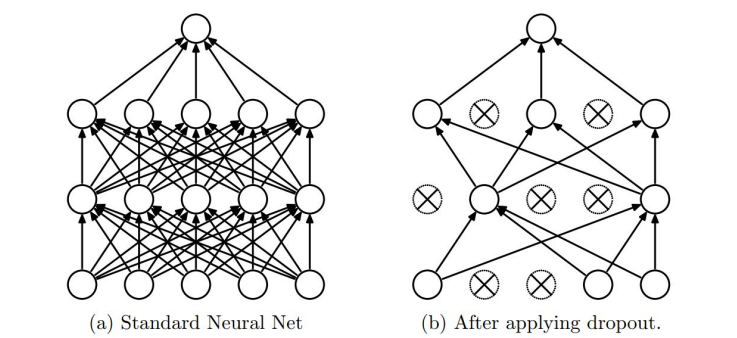

Dropout을 하면 뭐가 좋아요?   
1. 오버피팅 방지
2. 성능 향상
3. 매번 다른 형태의 구조를 학습하기
    - 여러 네트워크가 최종 결과를 내는 네트워크 앙상블의 효과를 얻을 수 있다.

#### **주의**  
Test set에서는 모든 node를 다 사용해서 결과값을 구해야 하기 때문에, evaluation mode, train mode를 나눠줘야 함.   

## **Code:mnist_nn_dropout**

In [ ]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import random

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#for reproducibility
random.seed(777) # 데이터 전처리 및 분할
torch.manual_seed(777) #랜덤 초기화
if device == 'cuda':
    torch.cuda.manual_seed_all

In [ ]:
# parameters
learning_rate = 0.01
training_epochs = 15
batch_size = 100

In [ ]:
#mnist dataset
mnist_train = dsets.MNIST(root='./',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)
mnist_test = dsets.MNIST(root='./',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 59887258.66it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 78506606.50it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 22877349.54it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14080213.43it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
#dataset loader
data_loader = torch.utils.data.DataLoader(dataset = mnist_train,
                                    batch_size = batch_size,
                                    shuffle = True,
                                    drop_last = True)

In [ ]:
#nn layers
linear1 = torch.nn.Linear(784, 512, bias=True)
linear2 = torch.nn.Linear(512, 512, bias=True)
linear3 = torch.nn.Linear(512, 512, bias=True)
linear4 = torch.nn.Linear(512, 512, bias=True)
linear5 = torch.nn.Linear(512, 10 , bias=True)
relu = torch.nn.ReLU()
dropout = torch.nn.Dropout(p=0.3) #probablity. 이번 step에서 얼마정도의 노드를 안 쓸건지

#Xaviar initialization
torch.nn.init.xavier_uniform_(linear1.weight)
torch.nn.init.xavier_uniform_(linear2.weight)
torch.nn.init.xavier_uniform_(linear3.weight)
torch.nn.init.xavier_uniform_(linear4.weight)
torch.nn.init.xavier_uniform_(linear5.weight)

#model
model = torch.nn.Sequential(linear1, relu, dropout,
                            linear2, relu, dropout,
                            linear3, relu, dropout,
                            linear4, relu, dropout,
                            linear5).to(device)

In [ ]:
#optimizer, cost
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
total_batch = len(data_loader)
model.train() #dropout = true
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:
        # reshape input image into [batch_size by 784]
        # label is not one-hot encoded
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 0.726792812
Epoch: 0002 cost = 0.762414455
Epoch: 0003 cost = 0.813949466
Epoch: 0004 cost = 0.792681098
Epoch: 0005 cost = 0.716842234
Epoch: 0006 cost = 0.699247539
Epoch: 0007 cost = 0.726510644
Epoch: 0008 cost = 0.733262599
Epoch: 0009 cost = 0.774044335
Epoch: 0010 cost = 0.756352901
Epoch: 0011 cost = 0.723708749
Epoch: 0012 cost = 0.790449142
Epoch: 0013 cost = 0.755999804
Epoch: 0014 cost = 0.787983418
Epoch: 0015 cost = 0.763651431
Learning finished


In [ ]:
#Test the model
with torch.no_grad():
    model.eval() # dropout = False

    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test#dim=1
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    #Get one and predict
    r = random.randint(0, len(mnist_test)-1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = model(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Accuracy: 0.9082000255584717
Label:  8
Prediction:  8
